# Puzzle generator

We construct a puzzle generator in this notebook 

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import os

import pprint
import itertools
from collections import defaultdict

# generate random integer values
from random import seed
from random import randint
import numpy as np
from pylab import array
from random import sample
import math


# An overview

We use the CUB-200 dataset to generate our puzzles : http://www.vision.caltech.edu/visipedia/CUB-200.html

Each image from the dataset will give rise to a puzzle as follows: We'll cut up the image into uniform square pieces of a given width(=height). We'll rotate each square puzzle piece randomly by 0/90/180/270 degrees and we'll shuffle the order of the square pieces randomly and return these randomly rotated pieces as numpy arrays in their shuffled order.


We'll also indicate what the top left corner piece is, to help our puzzle solver start off.


# Notations

## Labels and positions

Imagine cutting up the image into _r_ rows and _c_ cols so that each piece is a square. Row numbering starts from 0 and goes to r-1 where the top row is 0 and the bottom row is r-1. Similarly col numbering starts from 0 and goes to c-1 where the left most col is 0 and the right most col is c-1.

1. __Labels__
   - We say that the piece in row _i_ and col _j_ has __label__ _(i,j)_
   - Thus the list of labels for the image is [(0,0), (0,1), ..(0, _c_-1),(1,0), ..(1,_c_-1),.....(_r_-1,0), ...(_r_-1,_c_-1)]

Imaging serially scanning the rc square pieces in the image from 0_th_ row to the _r-1 th_ row, and in each row, scanning from the 0_th_ col to the _c-1 st_ col. The (0,0) piece gets scanned first, then the (0,1) piece and so on ..


2. __Positions__
   - We say that the _p_th piece that gets scanned has __position__ _p-1_
   - Thus the list of positions for the image is [0,1,..., _rc_ -1]
  





## Switching between labels and positions

In [2]:
def label_to_pos(label, cols):
        return label[0]*cols + label[1]

def pos_to_label(pos, cols):
        return (pos//cols, (pos % cols))

Let's test the conversions between labels and positions

In [3]:
label_to_pos((2,1),5)

11

In [4]:
pos_to_label(11,5)

(2, 1)

# Visualization

Here's a helper function to visualize the cutting up process and the labels and positions of pieces. Each piece is annotated with __label: position__

In [5]:
# Helper function to visualize the cutting up process.

def visualize_grid_and_labels(image_file_name, puzzle_square_piece_dim):
    """Draws the puzzle grid with each piece with its label : position
    """
    
    
    #opening the image as a PIL image object
    my_image = Image.open(image_file_name)
    original_image_length = my_image.size[0]
    original_image_width =  my_image.size[1] 
    
    #Each puzzle piece is a square of dimension puzzle_square_piece_dim
    puzzle_piece_length = puzzle_square_piece_dim
    puzzle_piece_width = puzzle_square_piece_dim
    
    #Resizing the image so that it can be cut up into integer number of square pieces
    rows = original_image_length // puzzle_piece_length
    cols =  original_image_length // puzzle_piece_width
    new_image_length = rows*puzzle_piece_length
    new_image_width = cols*puzzle_piece_width
    
    #Resizing the image so that it can be cut up into integer number of square pieces
    my_image = my_image.resize((new_image_length, new_image_width))
    
    # Set up figure
    my_dpi = 100 #font size + line thickness
    #fig=plt.figure(figsize=(float(w)/my_dpi,float(h)/my_dpi),dpi=my_dpi)
    fig = plt.figure(dpi = my_dpi)
    
    #subplot(mni) breaks the figure window into an m-by-n matrix of small subplots
    #and selects the i_th subplot for the current plot. 
    #The plots are numbered along the top row of the figure window, then the second row, and so forth.
    
    ax=fig.add_subplot(1,1,1)
    
    # Remove whitespace from around the image
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    
    
    # Set the gridding interval: here we use the major tick interval
    #Within each axis, there is the concept of a major tick mark, and a minor tick mark. 
    #Major ticks are usually bigger or more pronounced,
    #while minor ticks are usually smaller. 
    
    
    #each tick is puzzle_square_piece_dim units apart
    myInterval=puzzle_square_piece_dim
    loc = plticker.MultipleLocator(base=myInterval)
    
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    
    # Add the grid
    ax.grid(which='major', axis='both', linestyle='-',color='white')
    
    # Add the image
    ax.imshow(my_image)

    # Find number of gridsquares in x and y direction
    nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(myInterval)))
    ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(myInterval)))
    
    #nx = cols
    #ny = rows


    # Add some labels to the gridsquares
    for i in range(rows):
        y=myInterval/2+i*myInterval
        for j in range(cols):
            x=myInterval/2.+float(j)*myInterval
            ax.text(x,y,'({:d},{:d}) : {:d}'.format(i,j, label_to_pos((i,j), cols)),color='red',ha='center',va='center')

    plt.show()
       

    
    
    

In [6]:
sample_image_file_name = 'input_for_visualization.jpg'
sample_puzzle_square_piece_dim = 60

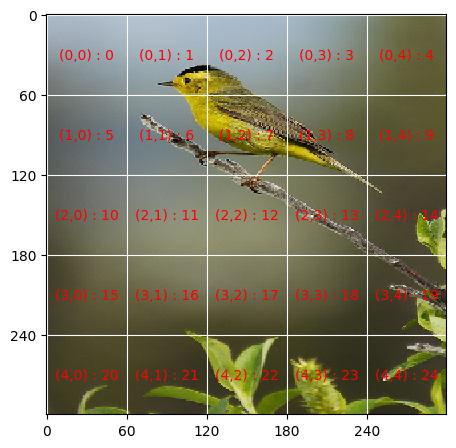

In [7]:
visualize_grid_and_labels(sample_image_file_name,sample_puzzle_square_piece_dim)

# Puzzle generating function

## Procedure

* We resize the image so that it can be cut up into integer number of square pieces of a given width = height


* We divide the image up into a grid into rows and cols so that each piece in the grid is a square piece of the required shape


* We scan the image grid serially (top to bottom row and in each row, from the leftmost col to the rightmost col) and create the puzzle pieces as we go along


* For each puzzle piece we create, we also randomly rotate it by 0, 90, 180 or 270 degrees counterclockwise

  -  __old_label__ of each puzzle piece is the position (i,j) in which it is in the original image
  - __orientation__ of a puzzle piece is (_degrees it is rotated by_)/90 
  
  
* We store the puzzle pieces as we generate them in a list called __puzzle_pieces__ and record each piece's orientation in a list called __puzzle_pieces_orientation__


* __list_of_old_labels__ is [(0,0), (0,1), ..(0, c-1), (1,0), ..(1,c-1),.....(r-1,0), ...(r-1,c-1)]


* We generate a permutation of the old labels called __new_labels__


* That is, a piece with __old label (x,y)__ and __old position  = p__ gets a __new label = new_labels[p]__. Note that its __new position__ remains __p__


* __Interpretation of the shuffling__
  
  If puzzle piece with __old label (x,y)__ gets a __new label (a,b)__, this means that in the shuffled image, the puzzle piece in row _a_ and col _b_ is actually the puzzle piece that was in row _x_ and col _y_ in the original image.
  
  
* We create a dictionary __new_to_old_label_dict__ which has new_labels as keys and values as old labels along with orientations of the corresponding puzzle pieces under consideration

        <pre>{new_label : (*old_label, orientation) }</pre>
        

* We identify the original top left piece's new label (i.e. the new label of the piece with old label (0,0) and also its orientation and store them in __top_left_piece_new_label_ and _top_left_piece_new_orientation_ respectively



* We store the shuffled pieces as numpy arrays in a list called __shuffled_puzzle_pieces_np__





We return the dictionary [new labels : old labels, angle of rotation of the old label piece] and the shuffled image pieces as numpy arrays






## Code

### Inputs 

* __image_file_name__ : Name of the image file
* __puzzle_square_piece_dim__ : width = height of each square puzzle piece we want to cut image into
* __display__ : Boolean (if true, the original image and the shuffled grid is displayed)


### Outputs
* rows : Number of rows we cut image into
* cols : Number of cols we cut image into 
* top_left_piece_new_label : new label of the original top left piece
* top_left_piece_orientation : orientation of the original top left piece
* new_to_old_label_dict : a dictionary which maps new labels to corresponding old labels, orientations
* shuffled_puzzle_pieces_np : a list of the shuffled pieces stored as numpy arrays



In [8]:
def get_puzzle_pieces(image_file_name,puzzle_square_piece_dim, display=False):
    """Return the shuffled and randomly rotated puzzle pieces 
       given an image and the dim of each square puzzle piece """
    
    #opening the image as a PIL image object
    my_image = Image.open(image_file_name)
    
    #getting original image length and width
    original_image_length = my_image.size[0]
    original_image_width =  my_image.size[1] 
    
    #Each puzzle piece is a square of dimension puzzle_square_piece_dim
    puzzle_piece_length = puzzle_square_piece_dim
    puzzle_piece_width = puzzle_square_piece_dim
    
    #Resizing the image so that it can be cut up into integer number of square pieces
    rows = original_image_length // puzzle_piece_length
    cols =  original_image_length // puzzle_piece_width
    new_image_length = rows*puzzle_piece_length
    new_image_width = cols*puzzle_piece_width
    no_of_puzzle_pieces = rows*cols     
    my_image = my_image.resize((new_image_length, new_image_width))
    
    
    #Sanity check print statements
    print("****************")
    print(f"puzzle_piece_length is {puzzle_piece_length}")
    print(f"puzzle_piece_width is {puzzle_piece_width}")
    print(f"no of rows are {rows}")
    print(f"no of cols are {cols}")
    print(f"no_of_puzzle_pieces are {no_of_puzzle_pieces}")

    
    
    #list_of_labels is [(0,0), (0,1), ..(0, c-1), (1,0), ..(1,c-1),.....(r-1,0), ...(r-1,c-1)]
    


    #We create these r*c number of pieces by cropping the image appropriately
    #We go from top to bottom row and in each row, from left to right cols.
    #For each puzzle piece we create, we also randomly rotate it by 0, 90, 180 or 270 degrees
    #We record how much we rotate each piece by as we do this in a list called puzzle_pieces_orientation
    #We store the puzzle pieces as we generate them in a list called puzzle_pieces
    
    
    puzzle_pieces = []
    puzzle_pieces_orientation = []
    list_of_labels = []
    i = 0
    j = 0
    
    while(i < rows):
        while(j < cols):
            list_of_labels.append((i,j))
            random_int = randint(0,3)
            angle_of_rotation = 90*(random_int)
            puzzle_pieces_orientation.append(random_int)
            puzzle_pieces.append(my_image.crop((j*puzzle_piece_width,i*puzzle_piece_length,(j+1)*puzzle_piece_width,(i+1)*puzzle_piece_length)).rotate(angle_of_rotation))
            j += 1
        i += 1
        j = 0
    
    
    #new_labels is a permutation of list_of_labels
    new_labels = sample(list_of_labels, len(list_of_labels))
   
    #puzzle piece with old label (x,y) gets a new label which is new_label[x*cols + y]  = (a,b) say.
    #i.e., in the shuffled image, the puzzle piece is row a and col b is
    #actually the puzzle piece that was in row x and col y in the original image.
    
    
    #new_to_old_label_dict takes as keys the new labels and returns values as old label 
    #along with the angle of rotations of the puzzle pieces under consideration
    
    top_left_piece_new_label= None
    new_to_old_label_dict = {}
    for new_label, old_label  in zip(new_labels, list_of_labels):
        x, y = old_label
        new_to_old_label_dict[new_label] = (x,y, puzzle_pieces_orientation[x*cols+y])
        if x==0 and y==0:
            top_left_piece_new_label = new_label
            top_left_piece_orientation = puzzle_pieces_orientation[x*cols+y]
    
    
    #We store the shuffled pieces as numpy arrays in a list
    #We again scan the shuffled image from top to botton row and in each row, scan from left to right cols
    
    shuffled_puzzle_pieces_np = []
    
    
    i = 0
    j = 0
    while(i < rows):
        while(j < cols):
            x, y, theta = new_to_old_label_dict[(i,j)] 
            shuffled_piece = puzzle_pieces[x*cols+y]
            shuffled_puzzle_pieces_np.append(array(shuffled_piece))
            j += 1
        i += 1
        j = 0
        
    if display:
        #font size + line thickness
        my_dpi = 100
        
        
        #Display original image
        fig_0 = plt.figure(dpi = my_dpi)
        plt.imshow(my_image)
        plt.title("Original image")
        plt.axis('off')
        
        
        #Display shuffled grid image
        fig = plt.figure(dpi = my_dpi)
        plt.title("Shuffled grid of puzzle pieces")
        plt.axis('off')


        #subplot(mni) breaks the figure window into an m-by-n matrix of small subplots
        #and selects the i_th subplot for the current plot. 
        #The plots are numbered along the top row of the figure window, then the second row, and so forth.

        for i, piece in enumerate(shuffled_puzzle_pieces_np):
                img = Image.fromarray(piece, 'RGB')
                ax=fig.add_subplot(rows,cols,i+1)
                ax.imshow(img)
                ax.axis('off')
        plt.show()

    
    return rows, cols, top_left_piece_new_label, top_left_piece_orientation, new_to_old_label_dict, shuffled_puzzle_pieces_np
    

# A sample puzzle

****************
puzzle_piece_length is 60
puzzle_piece_width is 60
no of rows are 5
no of cols are 5
no_of_puzzle_pieces are 25


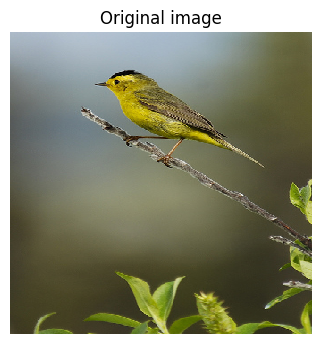

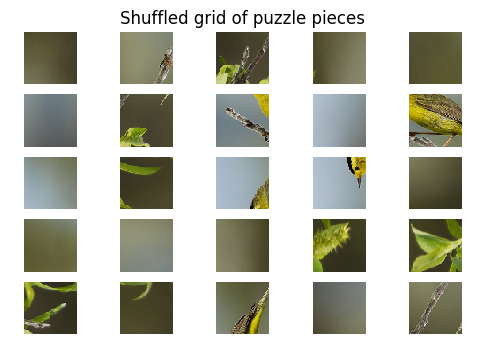

In [9]:
sample_puzzle = get_puzzle_pieces(sample_image_file_name,sample_puzzle_square_piece_dim, display=True)

In [10]:
print(f"top_left_piece_new_label = {sample_puzzle[2]}, top_left_piece_orientation = {sample_puzzle[3]}")

top_left_piece_new_label = (1, 3), top_left_piece_orientation = 1


In [11]:
pprint.pprint(sample_puzzle[4])

{(0, 0): (3, 0, 2),
 (0, 1): (2, 2, 3),
 (0, 2): (3, 4, 3),
 (0, 3): (3, 1, 3),
 (0, 4): (1, 4, 3),
 (1, 0): (1, 0, 1),
 (1, 1): (2, 4, 3),
 (1, 2): (1, 1, 0),
 (1, 3): (0, 0, 1),
 (1, 4): (1, 2, 0),
 (2, 0): (0, 3, 1),
 (2, 1): (4, 1, 2),
 (2, 2): (0, 2, 1),
 (2, 3): (0, 1, 1),
 (2, 4): (3, 3, 0),
 (3, 0): (0, 4, 3),
 (3, 1): (2, 1, 2),
 (3, 2): (3, 2, 1),
 (3, 3): (4, 3, 3),
 (3, 4): (4, 2, 1),
 (4, 0): (4, 4, 2),
 (4, 1): (4, 0, 2),
 (4, 2): (1, 3, 1),
 (4, 3): (2, 0, 0),
 (4, 4): (2, 3, 3)}


In [12]:
print(f"Each puzzle piece numpy array has shape (h,w,c) =  {sample_puzzle[5][0].shape}")

Each puzzle piece numpy array has shape (h,w,c) =  (60, 60, 3)
